In [4]:
using IonSim
using QuantumOptics

In [2]:
# Construct the system
C = Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])
L = Laser()
chain = LinearChain(
        ions=[C], comfrequencies=(x=3e6, y=3e6, z=1e6),
        selectedmodes=(;z=[1])
    )
chamber = Chamber(B=2.9e-4, Bhat=ẑ, iontrap=chain, lasers=[L])

# Set the laser parameters
L.k = (x̂ + ẑ)/√2
L.ϵ = (x̂ - ẑ)/√2
wavelength_from_transition!(L, C, ("S", "D"), chamber)

# Set pi_time to 4 μs
E = intensity_from_pitime!(1, 4e-6, 1, ("S", "D"), chamber)

# We'll linearly sweep through the laser's frequency over
# [-125, +125] kHz (detuned from the carrier transition) in a time Tp
Tp = 250
Δϕ = Tp * 1e-3
L.ϕ = t -> 2π * (-Δϕ/2 + (Δϕ / Tp) * t) * t

# And also smoothly turn on and off the laser's electric field strength
Ω = t -> E * sin(π * t/Tp)^2
L.I = Ω

# Build Hamiltonian
h = hamiltonian(chamber, rwa_cutoff=Inf, lamb_dicke_order=1, timescale=1e-6)

# Solve system
tout, sol = timeevolution.schroedinger_dynamic(0:.1:Tp, ions(chamber)[1]["S"] ⊗ modes(chamber)[1][0], h);

/Users/jspark971/.julia/conda/3/x86_64/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


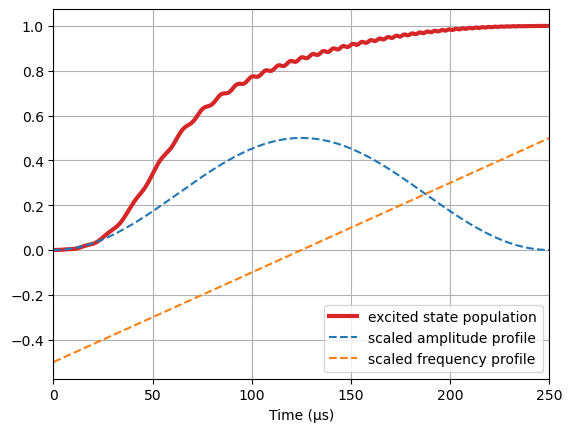

PyObject Text(0.5, 24.0, 'Time (μs)')

In [3]:
import PyPlot
const plt = PyPlot

plt.plot(tout, expect(ionprojector(chamber, "D"), sol),
        lw=3, color="C3", label="excited state population")
plt.plot(tout, @.(L.I(tout) / 2E),
        ls="--", label="scaled amplitude profile")
plt.plot(tout, @.(L.ϕ(tout) / (2π * Δϕ * tout)),
        ls="--", label="scaled frequency profile")
plt.xlim(tout[1], tout[end])
plt.legend(loc=4)
plt.grid()
plt.xlabel("Time (μs)")